# **1. Mise en place**

In [1]:
# Importer les modules nécessaires

import random

import cv2
import mediapipe as mp
import os
import csv

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

from matplotlib.ticker import MultipleLocator

In [2]:
# Fixer des seeds aléatoires pour la reproductibilité

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
# Vérifier si un GPU est disponbible et définir le device utilisé

# Vérifier si CUDA (GPU NVIDIA) ou MPS (Apple Silicon) est disponbible
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}") # Affichage du device utilisé (GPU ou CPU)

Using device: cpu


# **2. Chargement des données**

In [7]:
# Initialiser MediaPipe pour la détection de mains

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode = True, max_num_hands = 2, min_detection_confidence = 0.5)
mp_drawing = mp.solutions.drawing_utils

In [13]:
# Fonction pour extraire les landmarks d'une image
def extract_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        # Récupérer les landmarks pour chaque main détectée
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])  # Coordonnées X, Y, Z
            return landmarks
    print(f"Aucune main détectée pour {image_path}")
    return None

# Parcourir les dossiers et extraire les données
def process_dataset(dataset_path, output_csv):
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        # En-tête du fichier CSV
        header = ['label'] + [f'{coord}_{i}' for i in range(21) for coord in ['x', 'y', 'z']]
        writer.writerow(header)

        # Parcourir les dossiers
        for label in os.listdir(dataset_path):
            label_path = os.path.join(dataset_path, label)
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    landmarks = extract_landmarks(image_path)
                    if landmarks:
                        writer.writerow([label] + landmarks)

In [15]:
# Chemin où enregistrer les coordonnées de l'échantillon d'entraînement
train_dataset_path = "Train"
train_output_csv = "train_landmarks.csv"

## Exécution de l'extraction pour l'échantillon d'entraînement (déjà faite)
# process_dataset(train_dataset_path, train_output_csv)
# print(f"Données enregistrées dans {train_output_csv}")

In [17]:
# Chemins où enregistrer les coordonnées de l'échantillon de test
test_dataset_path = "Test"
test_output_csv = "test_landmarks.csv"

## Exécution de l'extraction pour l'échantillon de test (déjà faite)
# process_dataset(test_dataset_path, test_output_csv)
# print(f"Données enregistrées dans {test_output_csv}")

In [19]:
# Charger les données d'entraînement ainsi obtenues

data_train = pd.read_csv("train_landmarks.csv")
print(data_train.head())  # Afficher les premières lignes pour vérifier le chargement

   label       x_0       y_0           z_0       x_1       y_1       z_1  \
0  ENTER  0.313832  0.764376  2.474214e-07  0.358308  0.734033 -0.026857   
1  ENTER  0.650379  0.380406  2.110198e-07  0.603407  0.368063 -0.015487   
2  ENTER  0.663164  0.614228  1.384285e-07  0.619237  0.591525 -0.012178   
3  ENTER  0.338837  0.690563  3.175797e-07  0.293740  0.682436 -0.011694   
4  ENTER  0.716060  0.874130  3.947711e-07  0.661055  0.861623 -0.025433   

        x_2       y_2       z_2  ...      z_17      x_18      y_18      z_18  \
0  0.386194  0.675503 -0.038582  ... -0.034137  0.273438  0.577838 -0.052214   
1  0.568174  0.318842 -0.020643  ... -0.019743  0.653054  0.199351 -0.029746   
2  0.589870  0.539513 -0.016454  ... -0.018273  0.676231  0.433817 -0.025656   
3  0.258236  0.642395 -0.017841  ... -0.030567  0.360939  0.508950 -0.041258   
4  0.618185  0.820818 -0.042626  ... -0.042167  0.758279  0.681288 -0.056616   

       x_19      y_19      z_19      x_20      y_20      z_20 

In [23]:
# Charger les données de test ainsi obtenues

data_test = pd.read_csv("test_landmarks.csv")
print(data_test.head())  # Afficher les premières lignes pour vérifier le chargement

   label       x_0       y_0           z_0       x_1       y_1       z_1  \
0  ENTER  0.372713  0.992195  4.075158e-07  0.415978  0.971429 -0.018991   
1  ENTER  0.218966  0.684899  2.662443e-07  0.267944  0.652957 -0.020444   
2  ENTER  0.695835  0.743236  1.200198e-07  0.642324  0.708206 -0.010117   
3  ENTER  0.672564  0.667273  1.896680e-07  0.611416  0.630776 -0.015410   
4  ENTER  0.558197  0.951038  4.124097e-07  0.499413  0.938858 -0.023143   

        x_2       y_2       z_2  ...      z_17      x_18      y_18      z_18  \
0  0.443110  0.917652 -0.027041  ... -0.031439  0.340451  0.803522 -0.047341   
1  0.303630  0.585849 -0.023309  ... -0.006866  0.192741  0.467618 -0.015227   
2  0.607806  0.640412 -0.013044  ... -0.017123  0.698781  0.503783 -0.022862   
3  0.572631  0.555050 -0.021079  ... -0.020881  0.680259  0.403728 -0.028222   
4  0.452896  0.888823 -0.036276  ... -0.035082  0.588044  0.699659 -0.046850   

       x_19      y_19      z_19      x_20      y_20      z_20 

# **3. Traitement et analyse des données**

In [26]:
# Etape de scaling

scaler = MinMaxScaler()
features_train = data_train.iloc[:, 1:]  # Exclure la colonne des labels
features_test = data_test.iloc[:, 1:] # De même pour l'échantillon de test
normalized_features_train = scaler.fit_transform(features_train)
normalized_features_test = scaler.fit_transform(features_test)

In [28]:
# Remplacer les anciennes données par les données normalisées dans l'échantillon d'entraînement

data_train.iloc[:, 1:] = normalized_features_train
print(data_train.head()) # Affichage des données d'entraînement normalisées

   label       x_0       y_0       z_0       x_1       y_1       z_1  \
0  ENTER  0.329598  0.679027  0.780843  0.373168  0.673895  0.312188   
1  ENTER  0.662875  0.273039  0.747177  0.631281  0.284959  0.485181   
2  ENTER  0.675536  0.520269  0.680040  0.647952  0.522444  0.535528   
3  ENTER  0.354360  0.600981  0.845729  0.305172  0.619060  0.542895   
4  ENTER  0.727917  0.795074  0.917120  0.691990  0.809492  0.333856   

        x_2       y_2       z_2  ...      z_17      x_18      y_18      z_18  \
0  0.400932  0.646232  0.410156  ...  0.396241  0.287109  0.586272  0.419299   
1  0.590779  0.273370  0.583845  ...  0.524845  0.638448  0.199098  0.583771   
2  0.613413  0.504065  0.624400  ...  0.537979  0.659898  0.438945  0.613712   
3  0.267443  0.611621  0.610969  ...  0.428137  0.368093  0.515803  0.499499   
4  0.642952  0.798148  0.371002  ...  0.324492  0.735834  0.692096  0.387074   

       x_19      y_19      z_19      x_20      y_20      z_20  
0  0.293212  0.554767 

In [30]:
# De même pour l'échantillon de test

data_test.iloc[:, 1:] = normalized_features_test
print(data_test.head())

   label       x_0       y_0       z_0       x_1       y_1       z_1  \
0  ENTER  0.376631  0.858356  0.671157  0.389537  0.882544  0.752748   
1  ENTER  0.225509  0.526229  0.587608  0.226660  0.543601  0.739969   
2  ENTER  0.694237  0.589281  0.501129  0.638577  0.602400  0.830767   
3  ENTER  0.671363  0.507179  0.542320  0.604570  0.519993  0.784227   
4  ENTER  0.558948  0.813873  0.674052  0.481337  0.847879  0.716240   

        x_2       y_2       z_2  ...      z_17      x_18      y_18      z_18  \
0  0.393824  0.905300  0.768855  ...  0.493750  0.334718  0.838029  0.469998   
1  0.224196  0.550665  0.790357  ...  0.676078  0.203950  0.470873  0.663827   
2  0.594118  0.608982  0.849494  ...  0.599976  0.651949  0.510403  0.617749   
3  0.551339  0.517746  0.803205  ...  0.572091  0.635552  0.401039  0.585394   
4  0.405725  0.874487  0.715647  ...  0.466713  0.553913  0.724502  0.472964   

       x_19      y_19      z_19      x_20      y_20      z_20  
0  0.338549  0.768946 

In [32]:
# Séparation des features et des labels dans l'échantillon d'entraînement

X_train = data_train.iloc[:, 1:]  # Toutes les colonnes sauf les labels
y_train = data_train.iloc[:, 0]   # La colonne des labels
print(f"Caractéristiques de l'échantillon d'entraînement (X_train) : {X_train.shape}, labels (y_train) : {y_train.shape}")

Caractéristiques de l'échantillon d'entraînement (X_train) : (5158, 63), labels (y_train) : (5158,)


In [34]:
# De même pour l'échantillon de test

X_test = data_test.iloc[:, 1:] 
y_test = data_test.iloc[:, 0]   
print(f"Caractéristiques de l'échantillon de test (X_test) : {X_test.shape}, labels (y_test) : {y_test.shape}")

Caractéristiques de l'échantillon de test (X_test) : (1833, 63), labels (y_test) : (1833,)


In [36]:
def analyze_dataset(trainset, testset): # Fonction pour l'analyse des données

    # 1. Récupérer le total d'images dans chaque échantillon :
    
    print(f"Nombre d'images dans l'échantillon d'entraînement: {len(trainset)}")
    print(f"Nombre d'images dans l'échantillon de test : {len(testset)}")

    # 2. Rappeler le nombre de coordonnées (landmarks) par image :
    
    print(f"Nombre de landmarks par image : {trainset.shape[1]}")
    
    # 3. Compter le nombre d'images par classe dans les jeux de données :
    
    # Dictionnaires pour stocker le nombre d'images par classe
    train_class_counts = {}
    test_class_counts = {}
    # Parcourir chaque dossier (chaque classe) du jeu de données d'entraînement
    for class_name in os.listdir(train_dataset_path):
      class_path = os.path.join(train_dataset_path, class_name)
      # Vérifier que c'est bien un dossier
      if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        train_class_counts[class_name] = num_images
    # De même pour le jeu de données de test
    for class_name in os.listdir(test_dataset_path):
      class_path = os.path.join(test_dataset_path, class_name)
      if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        test_class_counts[class_name] = num_images
    # Afficher le nombre d'images par classe dans l'échantillon d'entraînement
    print("\nEchantillon d'entraînement :")
    for class_name, count in train_class_counts.items():
      print(f"Classe {class_name} -> {count} images")
    # De même pour l'échantillon de test
    print("\nEchantillon de test :")
    for class_name, count in test_class_counts.items():
      print(f"Classe {class_name} -> {count} images")

    # 4. Visualiser la distribution des classes dans les deux jeux de données :
    
    plt.figure(figsize=(10, 5))
    plt.title("Nombre d'images par classe dans les échantillons")
    plt.bar(train_class_counts.keys(), train_class_counts.values(), label = 'Train')
    plt.bar(test_class_counts.keys(), test_class_counts.values(), label = 'Test')
    plt.legend()

Nombre d'images dans l'échantillon d'entraînement: 5158
Nombre d'images dans l'échantillon de test : 1833
Nombre de landmarks par image : 63

Echantillon d'entraînement :
Classe ENTER -> 983 images
Classe FIRE -> 2000 images
Classe LEFT -> 784 images
Classe RIGHT -> 1464 images

Echantillon de test :
Classe ENTER -> 420 images
Classe FIRE -> 496 images
Classe LEFT -> 542 images
Classe RIGHT -> 464 images


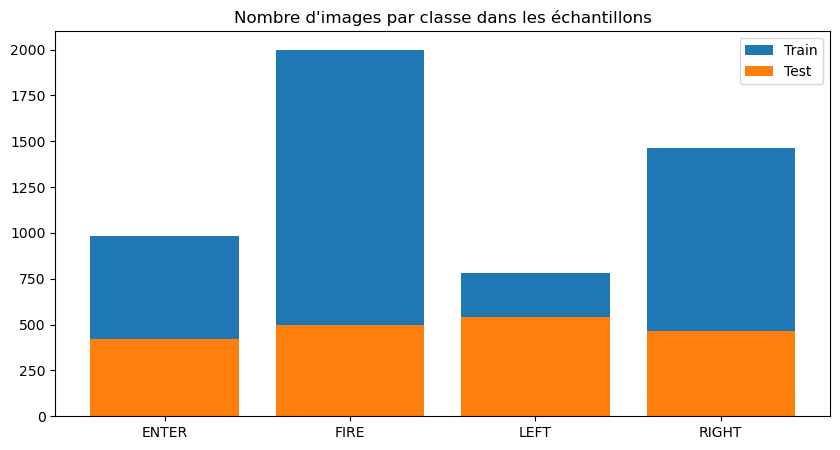

In [38]:
# Appeler la fonction pour analyser le jeu de données
analyze_dataset(X_train, X_test)

# **4. Augmentation des données**

In [42]:
# Définition d'une fonction pour augmenter les données 

def add_noise(landmarks, noise_level = 0.01): # Ajout de bruit aléatoire
    noise = np.random.normal(0, noise_level, landmarks.shape)
    return landmarks + noise

In [44]:
# Appliquer l'augmentation :

X_train_augmented = []
X_test_augmented = []

# Parcourir les lignes du DataFrame d'entraînement :

for i in range(X_train.shape[0]):
    original = X_train.iloc[i, :]
    augmented = [add_noise(original)]
    X_train_augmented.extend(augmented)

# Pareil pour le DataFrame de test :

for i in range(X_test.shape[0]):
    original = X_test.iloc[i, :]
    augmented = [add_noise(original)]
    X_test_augmented.extend(augmented)

X_train_augmented = np.array(X_train_augmented)  # Convertir les données d'entraînement augmentées en un tableau NumPy
X_test_augmented = np.array(X_test_augmented)  # Pareil pour les données de test

print(f"Forme de l'échantillon d'entraînement augmenté : {X_train_augmented.shape}")  # Vérifier la forme finale des données augmentées
print(f"Forme de l'échantillon de test augmenté : {X_test_augmented.shape}")  # Pareil pour les données de test

Forme de l'échantillon d'entraînement augmenté : (5158, 63)
Forme de l'échantillon de test augmenté : (1833, 63)


# **5. Construction du modèle**

In [46]:
# Encoder les labels en tant que nombres entiers

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Conversion des labels
y_test = label_encoder.transform(y_test)  # Même transformation pour les données de test

print(f"Labels encodés : {y_train}")  # Vérifier les labels transformés
print("ENTER -> 0\nFIRE -> 1\nLEFT -> 2\nRIGHT -> 3")

Labels encodés : [0 0 0 ... 3 3 3]
ENTER -> 0
FIRE -> 1
LEFT -> 2
RIGHT -> 3


In [48]:
# Conversion des données en tenseurs PyTorch pour le modèle à venir :

X_train_augmented_tensor = torch.tensor(X_train_augmented, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_augmented_tensor = torch.tensor(X_test_augmented, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Créer des DataSets à partir des tenseurs :

train_dataset = TensorDataset(X_train_augmented_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_augmented_tensor, y_test_tensor)

# Créer des DataLoaders à partir des DataSets pour charger les données par lots (batches) de taille 32 :

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True) # Répartition aléatoire des images dans les batches
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False) # Pas besoin de répartition aléatoire pour l'échantillon de test

print("DataLoaders prêts !")

DataLoaders prêts !


In [50]:
# Définition d'un MultiLayer Perceptron à entraîner sur notre jeu de données

class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return self.model(x)

In [52]:
# Initialiser le modèle

input_size = X_train_augmented.shape[1]  # Nombre de caractéristiques (landmarks) par image (= 63)
num_classes = len(np.unique(y_train))  # Nombre de classes : (= 4)

model = MLP(input_size, num_classes) # Instancier le modèle
print(model)  # Afficher la structure du modèle

MLP(
  (model): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=4, bias=True)
    (9): Softmax(dim=1)
  )
)


In [54]:
# Inférer une image d'exemple avec le modèle

dataiter = iter(train_loader)
ex_images, labels = next(dataiter)
ex_images = ex_images
image = ex_images[0]
print(f"Nombre de landmarks pour l'image d'exemple : {image.shape[0]}")
outputs = model(image.unsqueeze(0))  # Ajouter la dimension batch
print(f"Prédiction de dimension {outputs.shape[1]}")
print(f"Prediction : {outputs}")

Nombre de landmarks pour l'image d'exemple : 63
Prédiction de dimension 4
Prediction : tensor([[0.2456, 0.2697, 0.2619, 0.2228]], grad_fn=<SoftmaxBackward0>)


# **6. Entraînement du modèle**

In [62]:
# Fonction d'entraînement et d'évaluation du modèle

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs = 10) :

    # Listes pour sauvegarder les métriques
    
    train_losses = [] # Pour sauvegarder les pertes moyennes d'entraînement par epoch
    test_losses = [] # Pour sauvegarder les pertes moyennes de test par epoch
    test_accuracies = [] # Pour sauvegarder les précisions (accuracies) de test par epoch

    # Boucle d'entraînement
    
    for epoch in range(num_epochs) :

        # Phase d'entraînement
        
        model.train() # Mode entraînement
        running_loss = 0 # Pour sauvegarder la perte de l'epoch actuelle

        bar = tqdm(enumerate(train_loader, 0), total = len(train_loader)) # Affichage de l'avancée de l'entraînement sur l'epoch actuelle
        for i, data in bar :
            inputs, labels = data # Récupération des features et labels de la batch actuelle
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # Réinitialisation du gradient
            outputs = model(inputs) # Passage des features de la batch en cours dans le modèle MLP
            loss = criterion(outputs, labels) # Calcul de la perte entre les labels et les prédictions du modèle
            loss.backward() # Backpropagation
            optimizer.step() # Mise à jour des poids
            running_loss += loss.item() # Incrémentation de la perte totale de l'epoch actuelle

        # Phase d'évaluation
        
        model.eval() # Mode évaluation pour désactiver le calcul du gradient et gagner en ressources

        # Métriques pour calculer la précision (accuracy) sur chaque epoch
        
        test_loss = 0 # Pour le suivi de la perte
        test_correct = 0 # Pour le suivi du nombre de bonnes prédictions
        test_total = 0 # Pour le suivi du nombre total de prédictions

        test_bar = tqdm(enumerate(test_loader, 0), total = len(test_loader)) # Affichage de l'avancée de l'évaluation sur l'époque actuelle
        for i, data in test_bar:
            inputs, labels = data # Récupération des features et labels de la batch actuelle
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) # Passage des features dans le modèle MLP
            test_loss += criterion(outputs, labels).item() # Calcul de la perte entre les labels et les prédictions du modèle
            _, predicted = torch.max(outputs.data, 1) # Récupération des prédictions
            test_total += labels.size(0) # Incrémentation du total de prédictions effectuées
            test_correct += (predicted == labels).sum().item() # Incrémentation du total de prédictions correctes

        # Afficher les métriques
        
        train_loss = running_loss / len(train_loader) # Perte moyenne par batch d'entraînement sur l'epoch actuelle
        test_loss = test_loss / len(test_loader) # Perte moyenne par batch de test sur l'epoch actuelle
        test_acc = 100 * test_correct / test_total # Précision (ou accuracy) du modèle en test sur l'epoch actuelle
        print(f' Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f},'
              f'Test Acc: {test_acc:.2f} %, '
              )

        # Enregistrement des métriques de l'epoch actuelle
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    return train_losses, test_losses, test_accuracies

In [64]:
# Définition des paramètres d'entraînement et d'évaluation

criterion = nn.CrossEntropyLoss()  # Perte adaptée pour la classification multiclasses comme ici
optimizer = optim.Adam(model.parameters(), lr = 0.001)  # Optimiseur Adam et taux d'apprentissage de 0.001

In [74]:
# Lancement de l'entraînement et de l'évaluation du modèle pour 5 epochs

num_epochs = 5 # Nombre d'epochs pour l'entraînement et l'évaluation

train_losses, test_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs)

100%|██████████| 58/58 [00:00<00:00, 272.08it/s]


 Epoch 1/5, Train Loss: 0.8054, Test Loss: 1.0098,Test Acc: 72.61 %, 


100%|██████████| 58/58 [00:00<00:00, 302.28it/s]


 Epoch 2/5, Train Loss: 0.8051, Test Loss: 1.0026,Test Acc: 73.32 %, 


100%|██████████| 58/58 [00:00<00:00, 329.54it/s]


 Epoch 3/5, Train Loss: 0.8012, Test Loss: 0.9419,Test Acc: 79.81 %, 


100%|██████████| 58/58 [00:00<00:00, 313.01it/s]


 Epoch 4/5, Train Loss: 0.8031, Test Loss: 0.9649,Test Acc: 77.14 %, 


100%|██████████| 58/58 [00:00<00:00, 323.52it/s]

 Epoch 5/5, Train Loss: 0.8051, Test Loss: 0.9559,Test Acc: 78.29 %, 


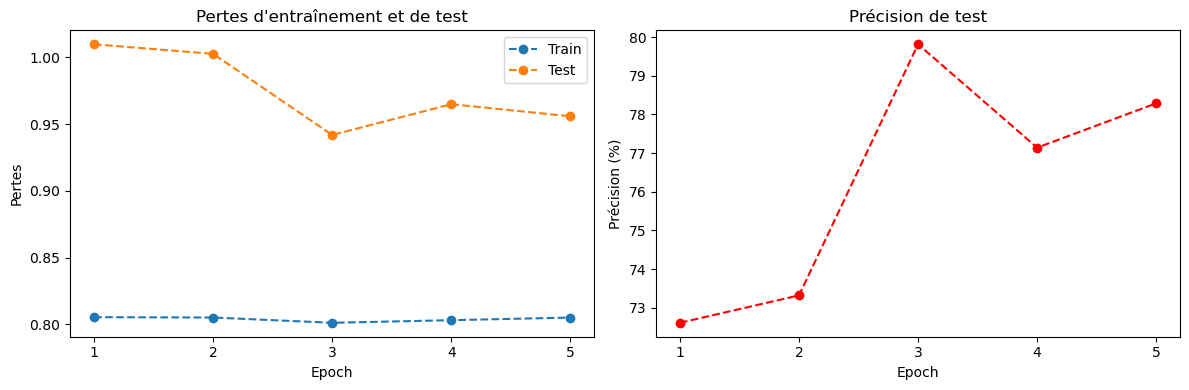

In [76]:
# Tracer les métriques d'entraînement et de test en fonction des epochs

plt.figure(figsize = (12, 4)) # Définition de la taille de la zone de graphiques

plt.subplot(1, 2, 1) # Graphique d'évolution des pertes d'entraînement et de test
plt.plot(np.arange(1, num_epochs + 1, step = 1), train_losses, label = 'Train', linestyle = 'dashed', marker = 'o')
plt.plot(np.arange(1, num_epochs + 1, step = 1), test_losses, label = 'Test', linestyle = 'dashed', marker = 'o')
plt.title("Pertes d'entraînement et de test")
plt.xlabel('Epoch')
plt.ylabel('Pertes')
plt.legend()
plt.gca().xaxis.set_major_locator(MultipleLocator(1))

plt.subplot(1, 2, 2) # Graphique d'évolution de la précision (accuracy) de test
plt.plot(np.arange(1, num_epochs + 1, step = 1), test_accuracies, linestyle = 'dashed', marker = 'o', color = 'red')
plt.title('Précision de test')
plt.xlabel('Epoch')
plt.ylabel('Précision (%)')
plt.gca().xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show() # Affichage des graphiques

In [78]:
# Enregistrement des poids du modèle entraîné

torch.save(model.state_dict(), "model.pth")